In [1]:
# load modules and data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import inspect
from whygreedy import *
from whygreedy.algo import find_greedy_first_choices

# set up plotting env
sns.set_theme(style="whitegrid", palette="pastel")
plt.rcParams.update({'font.size': 14})


In [2]:
# load data precalculated by `calculate.py`
def load():
    # preloaded pairs
    # a `pair` is a tuple of (reactant, product list), each pair corresponds to a reaction
    mp_oxidation_pairs = pkl_load("data/mp_oxidation_pairs.pkl")

    # precomputed enthalpies and x_i using different methods, each record corresponds to a pair (they have the same list index)
    mp_oxidation_records = pkl_load("data/mp_oxidation_records.pkl")

    # look up table for volume and cell
    mpid_to_vol_nsites = dict()
    for d in json_load("data/mp.json.gz"):
        mpid = d["task_id"]
        v = d["volume"]
        nsites = d["nsites"]
        mpid_to_vol_nsites[mpid] = (v, nsites)

    mpid_to_oxidation_pair = {p[0].mpid : p for p in mp_oxidation_pairs}

    return mp_oxidation_records, mpid_to_oxidation_pair, mp_oxidation_pairs

mp_oxidation_records, mpid_to_oxidation_pair, mp_oxidation_pairs= load()

loaded mp_oxidation_pairs.pkl in: 0.3588 s
loaded mp_oxidation_records.pkl in: 0.3410 s


In [3]:
# Section 1:
# compare greedy vs LP code
def count_dry_source_code(s:str):
    dry_lines = 0
    for line in s.split("\n"):
        if line.strip().startswith("#"):
            continue
        elif len(line.strip()) == 0:
            continue
        else:
            dry_lines += 1
    return dry_lines

def count_implementation(func_list):
    return sum(count_dry_source_code(inspect.getsource(f)) for f in func_list)

def compare_implementation_counts():
    greedy = count_implementation([find_greedy, find_greedy_first_choices, calculate_ranking_parameter])
    lp = count_implementation([find_lp])
    print("Dry lines greedy vs lp: {} vs {}".format(greedy, lp))

compare_implementation_counts()

Dry lines greedy vs lp: 76 vs 37


Greedy: max diff = -1.4801 eV/atom, mean diff = -0.2089
mean diff including zeros = -0.1186
qualitative diff = 22504 same as quantitative diff?: True


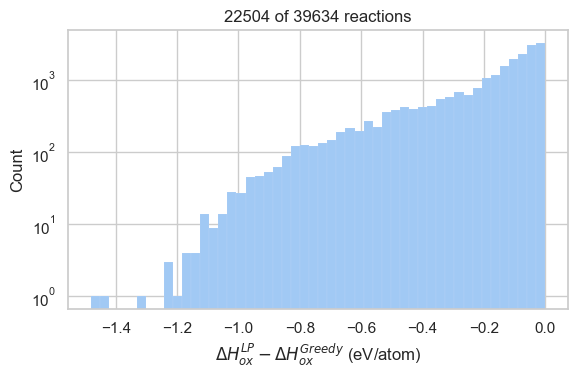

In [4]:
# Section 2:
# Fig. 1 nonzero diff between LP and greedy (Lazy-F3) for oxidation reactions
# note there are different implementations of the greedy algorithm described in
# the original paper by [Twyman et al.](Chem. Mater. 2022, 34, 2545-2552),
# we use the `Lazy-F3` here which is the one found in the source code provided by Twyman et al.
# for results from other implementations, see the `ChemRxiv` branch of this repository
def set_small_to_zeros(a: list[float], eps=1e-5):
    """supress small values in a list of float"""
    a = np.array(a)
    a[np.abs(a) < eps] = 0
    return a

def is_qualitative_diff(sol1, sol2):
    """test if nonzero values have different indices from two solutions"""
    sol_lazy = set_small_to_zeros(sol1).astype(bool)
    sol_exact = set_small_to_zeros(sol2).astype(bool)
    for i in range(len(sol_lazy)):
        if sol_lazy[i] != sol_exact[i]:
            return True
    return False

def plot_greedy_vs_exact_hist(records, eps=1e-5, reaction_type="ox"):
    nonzero_diff_lazy = []
    lazy_wrong = []
    lazy_wrong_quali = []
    for i, record in enumerate(records):
        dh_lazy = record["dh_lazy_f3"]
        dh_lp = record["dh_lp"]
        diff_lazy = dh_lp - dh_lazy
        sol_lazy = record["sol_lazy_f3"]
        sol_lp = record["sol_lp"]

        # exact should never be worse
        assert diff_lazy < eps

        if is_qualitative_diff(sol_lp, sol_lazy):
            lazy_wrong_quali.append(i)

        if abs(diff_lazy) > eps:
            lazy_wrong.append(i)
            nonzero_diff_lazy.append(diff_lazy)

    fig, ax = plt.subplots(figsize=(6, 4))
    palette = iter(sns.color_palette(n_colors=6))
    name, data, ax, quali, quanti = 'Greedy', nonzero_diff_lazy, ax, lazy_wrong_quali, lazy_wrong
    ax.hist(data, linewidth=0.05, bins=50, facecolor=next(palette))
    ax.set_yscale("log")
    ax.set_title("{} of {} reactions".format(len(data), len(records)))
    ax.set_xlabel(r"$\Delta H^{{LP}}_{{{}}} - \Delta H^{{{}}}_{{{}}}$ (eV/atom)".format(reaction_type, name, reaction_type))
    ax.set_ylabel("Count", fontsize=12)
    fig.tight_layout()

    # print info
    print("{}: max diff = {:.4f} eV/atom, mean diff = {:.4f}".format(name, min(data), np.mean(data)))
    print("mean diff including zeros = {:.4f}".format(sum(data)/len(records)))
    print("qualitative diff = {}".format(len(quali)), "same as quantitative diff?: {}".format(set(quali) == set(quanti)))
    return fig, lazy_wrong


fig, lazy_wrong = plot_greedy_vs_exact_hist(mp_oxidation_records, reaction_type="ox")
figname = "fig1"
fig.savefig("float/{}.eps".format(figname), bbox_inches="tight")
fig.savefig("float/{}.tiff".format(figname), bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})

In [5]:
# Section 2:
# examples of different Greedy (Lazy-F3) and LP solutions
def formula_dict_to_string(d:dict):
    return " ".join(["{}{:.3f}".format(k, v) for k, v in d.items()])

def format_solution(oxides: list[Compound], solution:np.ndarray) -> str:
    s = ""
    final = 0
    for i, oxi in zip(solution, oxides):
        if is_close_to_zero(i):
            continue
        s += "\t{:.4f} -- {} -- {:.2f} -- {}\n".format(i, formula_dict_to_string(oxi.normalized_formula), oxi.formation_energy_per_atom, oxi.mpid)
        final += oxi.formation_energy_per_atom * i
    s += "\tformation enthalpy sum of products: {:.6f}".format(final)
    return s

def print_high_dh_diff(records, pairs, greedy_field_suffix="lazy_f3", k=5, reverse=False):
    assert len(records) == len(pairs)
    dh_diff_records = []
    for i in range(len(records)):
        reactant, products = pairs[i]
        ddh = records[i]["dh_lp"] - records[i]["dh_{}".format(greedy_field_suffix)]
        if abs(ddh) < 1e-5:
            continue
        r = {
            "reactant": reactant,
            "products": products,
            "sol_greedy": records[i]["sol_{}".format(greedy_field_suffix)],
            "sol_lp": records[i]["sol_lp"],
            "ddh": ddh,
        }
        dh_diff_records.append(r)

    high_h_diff= sorted(dh_diff_records, key=lambda x:x["ddh"], reverse=reverse)
    for r in high_h_diff[:k]:
        original = r["reactant"]
        oxides = r["products"]
        sol_greedy = r["sol_greedy"]
        sol_lp = r["sol_lp"]
        print("="*6)
        print("Reactant: " + formula_dict_to_string(original.normalized_formula) + "\t" + original.mpid)
        print("EXACT solution:")
        print(format_solution(oxides, sol_lp))
        print("{} GREEDY solution:".format(greedy_field_suffix))
        print(format_solution(oxides, sol_greedy))

print("***"*6 + "High to low")
print_high_dh_diff(mp_oxidation_records, mp_oxidation_pairs, "lazy_f3", 3, reverse=False)

******************High to low
Reactant: Sr0.500 Se0.250 S0.250	mp-1218707
EXACT solution:
	1.5000 -- Sr0.167 S0.167 O0.667 -- -2.80 -- mp-5285
	1.5000 -- Sr0.167 Se0.167 O0.667 -- -2.16 -- mp-4092
	formation enthalpy sum of products: -7.448088
lazy_f3 GREEDY solution:
	1.0000 -- S0.250 O0.750 -- -1.75 -- mp-2414
	0.8750 -- Se0.286 O0.714 -- -1.03 -- mp-27358
	1.5000 -- Sr0.333 O0.667 -- -2.21 -- mp-2697
	formation enthalpy sum of products: -5.967983
Reactant: Sr0.500 Se0.375 S0.125	mp-1218389
EXACT solution:
	0.7500 -- Sr0.167 S0.167 O0.667 -- -2.80 -- mp-5285
	2.2500 -- Sr0.167 Se0.167 O0.667 -- -2.16 -- mp-4092
	formation enthalpy sum of products: -6.966090
lazy_f3 GREEDY solution:
	0.5000 -- S0.250 O0.750 -- -1.75 -- mp-2414
	1.3125 -- Se0.286 O0.714 -- -1.03 -- mp-27358
	1.5000 -- Sr0.333 O0.667 -- -2.21 -- mp-2697
	formation enthalpy sum of products: -5.542496
Reactant: Gd0.333 S0.333 F0.333	mp-3799
EXACT solution:
	2.3333 -- Gd0.143 S0.143 O0.571 F0.143 -- -3.07 -- mp-16801
	form